In [4]:

import statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
df = pd.read_csv('combined_data.csv')

In [6]:
cesar = df[df['Player'] == 'César Azpilicueta']


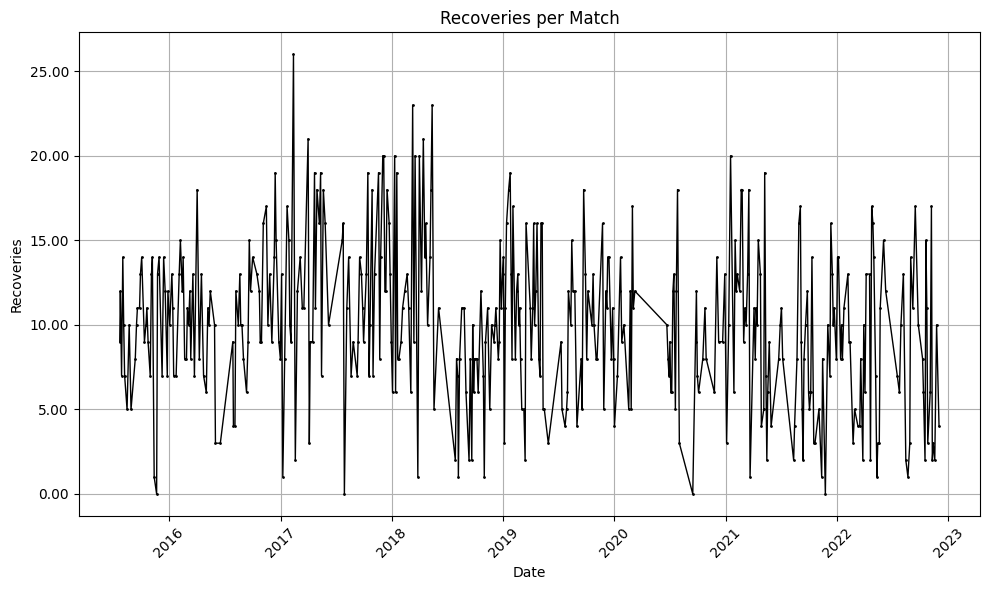

In [7]:
df = cesar[['Date', 'Recoveries']]
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
# df = df[(df != 0).all(axis=1)]

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Recoveries'], marker='o', linestyle='-', color='black',markersize = 1,linewidth=1)
plt.title('Recoveries per Match')
plt.xlabel('Date')
plt.ylabel('Recoveries')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adfuller(df['Recoveries'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output


Test Statistic                -5.993027e+00
p-value                        1.727520e-07
#Lags Used                     5.000000e+00
Number of Observations Used    4.130000e+02
Critical Value (1%)           -3.446283e+00
Critical Value (5%)           -2.868564e+00
Critical Value (10%)          -2.570511e+00
dtype: float64

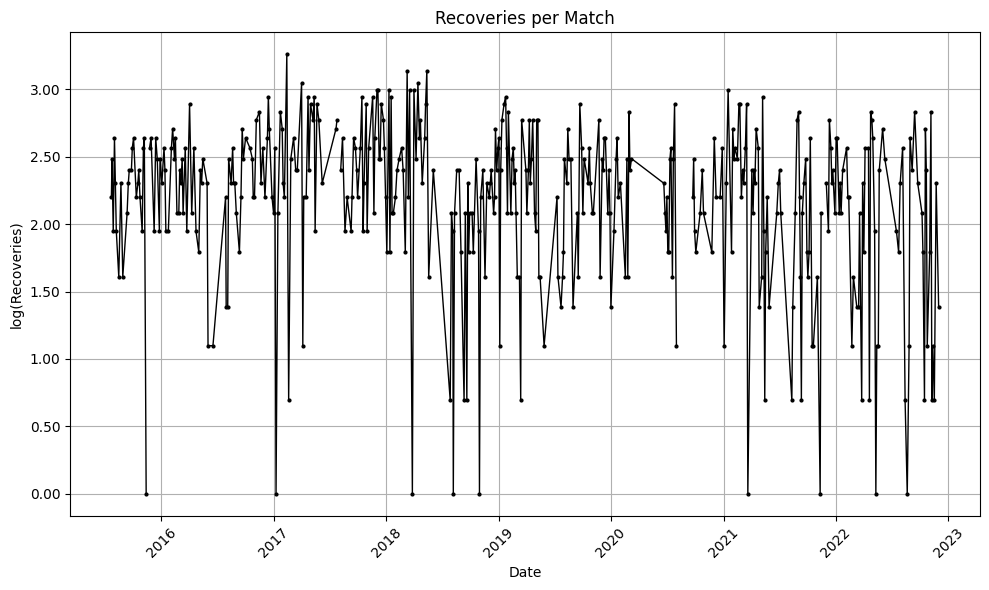

In [9]:
df['log_Recoveries'] = np.log(df['Recoveries'])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['log_Recoveries'], marker='o', linestyle='-', color='black',markersize = 2,linewidth=1)
plt.title('Recoveries per Match')
plt.xlabel('Date')
plt.ylabel('log(Recoveries)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

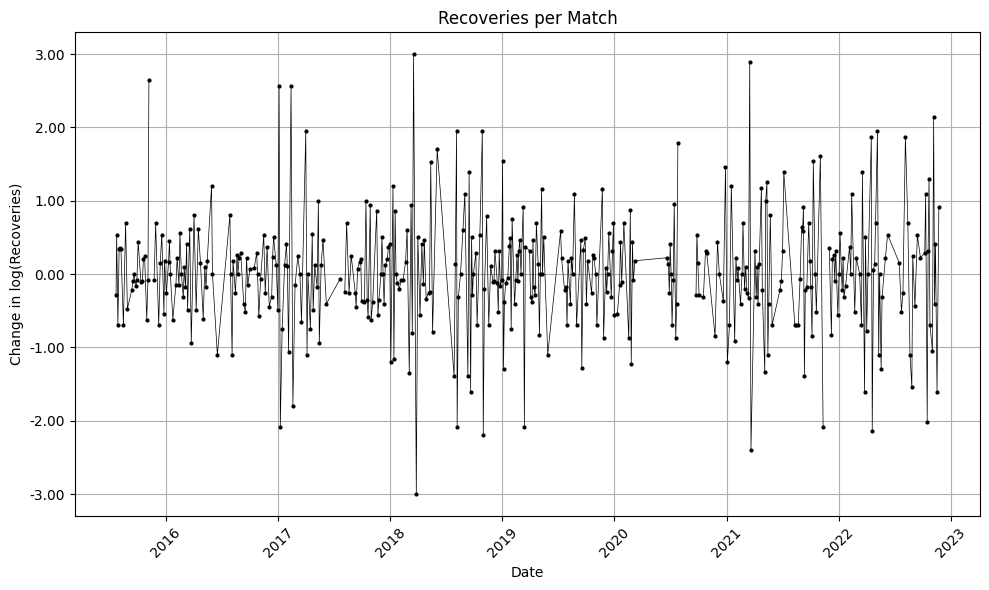

In [10]:
# Calculate the first difference 
df['log_Recoveries_diff'] = df['log_Recoveries'].diff()

# Plotting the first difference of the log-transformed series
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['log_Recoveries_diff'], marker='o', linestyle='-', color='black', markersize=2,linewidth=0.5)
plt.title('Recoveries per Match')
plt.xlabel('Date')
plt.ylabel('Change in log(Recoveries)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
import numpy as np

# Replace infinite values with NaN
df['log_Recoveries_diff'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
df.dropna(subset=['log_Recoveries_diff'], inplace=True)

# proceed with the ADF test
adf_result = adfuller(df['log_Recoveries_diff'])



In [12]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
# adf_result = adfuller(df['log_Recoveries_diff'].dropna())

adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                -7.731698e+00
p-value                        1.120939e-11
#Lags Used                     1.300000e+01
Number of Observations Used    3.960000e+02
Critical Value (1%)           -3.446972e+00
Critical Value (5%)           -2.868866e+00
Critical Value (10%)          -2.570673e+00
dtype: float64

<Figure size 1200x600 with 0 Axes>

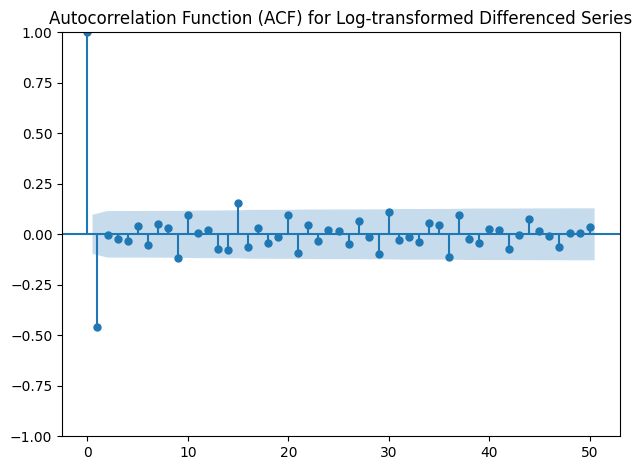

<Figure size 1200x600 with 0 Axes>

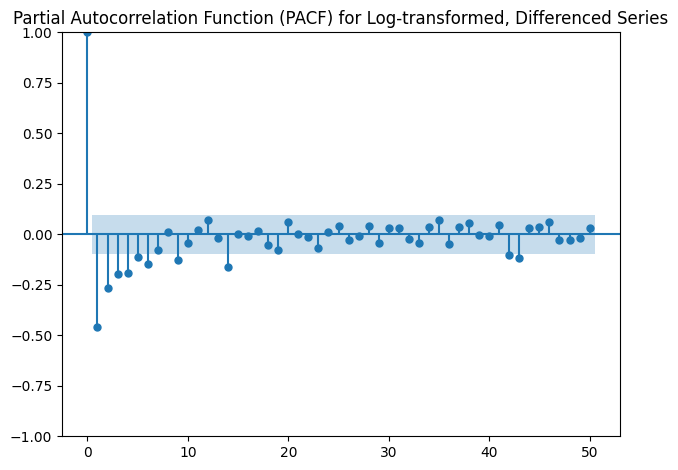

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df['log_Recoveries_diff'].dropna(), lags=50, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Differenced Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df['log_Recoveries_diff'].dropna(), lags=50, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed, Differenced Series')
plt.tight_layout()

plt.show()

In [14]:
from pmdarima import auto_arima
import pandas as pd

# Note: We drop the first NaN value that results from differencing
series = df['Recoveries'].dropna()
series.index = pd.to_datetime(df['Date'])  


# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20, 
                        m=12,  
                        start_P=0, start_Q=0, 
                        max_P=20, max_Q=20,
                        seasonal=False,  
                        D=1,  
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3144.129, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2616.048, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2917.998, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2521.923, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2495.458, Time=0.07 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=2465.947, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=2456.991, Time=0.12 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=2414.054, Time=0.43 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2414.277, Time=0.26 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=2415.965, Time=0.53 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=2417.485, Time=0.69 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2415.493, Time=0.29 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=2417.722, Time=0.43 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : 

In [15]:
# Extract the order (p, d, q)
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (4, 0, 1)
Seasonal order: (0, 0, 0, 0)


In [16]:
from tqdm import trange
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split the dataset into training and test sets
train_size = int(len(series) * 0.95)
series_train, series_test = series[:train_size], series[train_size:]

history = series_train.values.copy()
predictions = []
confidence_intervals = []

# Rolling forecast origin
for t in trange(len(series_test)):
    # Fit the SARIMA model on the history
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)  # Suppress fitting messages
    
    # Forecast the next point and get the 95% confidence interval
    forecast_result = model_fit.get_forecast(steps=1)
    yhat = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)  # 95% confidence interval
    
    predictions.append(yhat[0])  # Access forecast result correctly
    confidence_intervals.append(conf_int[0])  # Store confidence interval for each forecast
    
    # Correctly add the actual observation from series_test to history for the next loop
    actual_obs = series_test.iloc[t]  # Use .iloc[t] to correctly access the observation
    history = np.append(history, actual_obs)

100%|██████████| 21/21 [00:06<00:00,  3.29it/s]


Test RMSE: 2.684540405402945


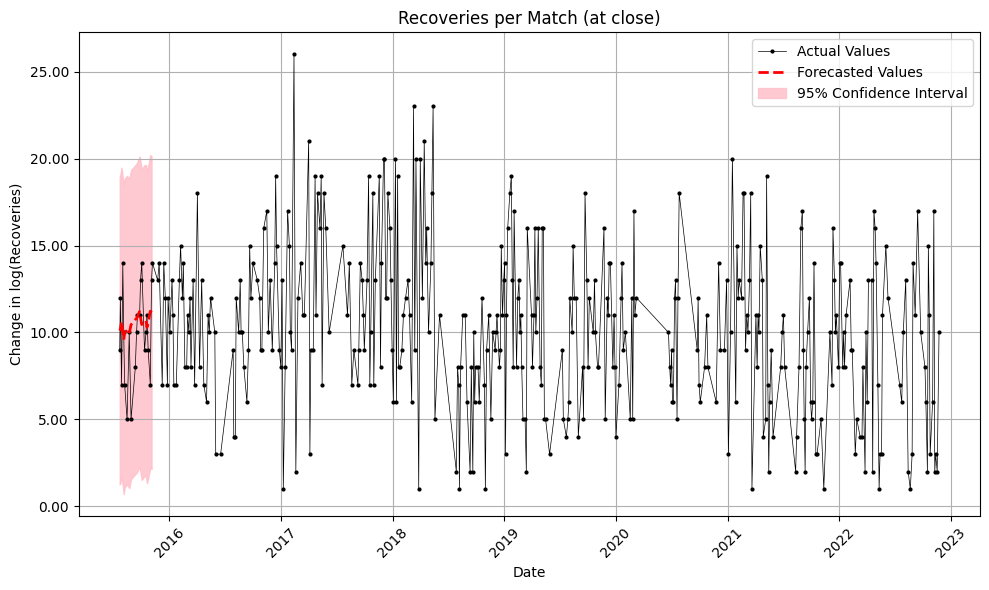

In [17]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')

# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Recoveries per Match (at close)')
plt.xlabel('Date')
plt.ylabel('Change in log(Recoveries)')
plt.grid(True)
# Manually format y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

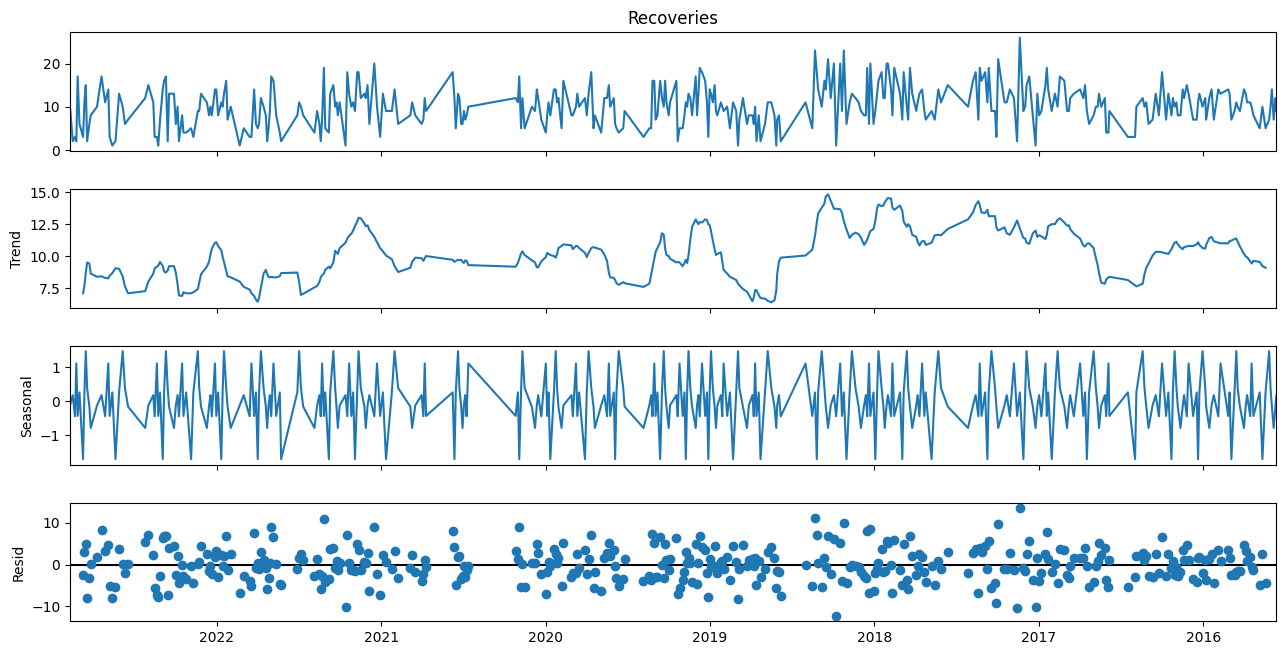

In [18]:
df['Date'] = pd.to_datetime(df['Date'])  # Assuming you have a 'Date' column
df.set_index('Date', inplace=True)
decomposition = sm.tsa.seasonal_decompose(df['Recoveries'], model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

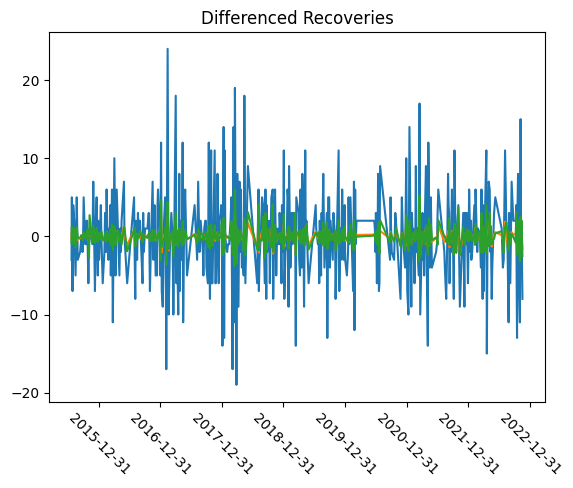

In [19]:

# Differencing
recoveries_diff = df.diff().dropna()
recoveries_diff.index = pd.to_datetime(recoveries_diff.index)
yearly_index = recoveries_diff.groupby(pd.Grouper(freq='Y')).mean().index

# Plot the differenced time series
plt.plot(recoveries_diff)
plt.title('Differenced Recoveries')
plt.xticks(yearly_index, rotation=-45)
plt.show()

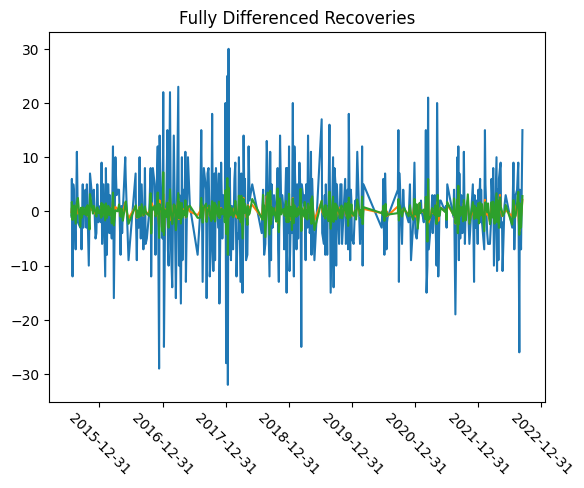

In [20]:
both_diff = recoveries_diff.diff(12).dropna()

# Plot the fully differenced time series
plt.plot(both_diff)
plt.title('Fully Differenced Recoveries')
plt.xticks(yearly_index, rotation=-45)
plt.show()

In [21]:
from statsmodels.tsa.stattools import adfuller

# Applying the Augmented Dickey-Fuller test on the first-differenced log-transformed series
# Note: We drop the first NaN value that results from differencing
adf_result = adf_result = adfuller(both_diff.iloc[:, 0])


adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

adf_output

Test Statistic                -8.628786e+00
p-value                        5.831671e-14
#Lags Used                     1.700000e+01
Number of Observations Used    3.790000e+02
Critical Value (1%)           -3.447722e+00
Critical Value (5%)           -2.869196e+00
Critical Value (10%)          -2.570849e+00
dtype: float64

<Figure size 1200x600 with 0 Axes>

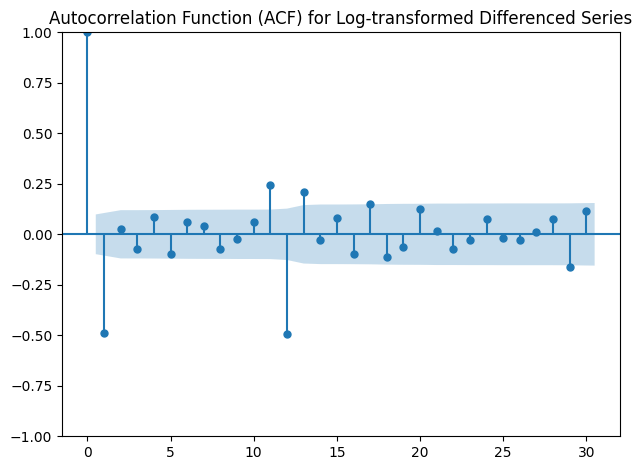

<Figure size 1200x600 with 0 Axes>

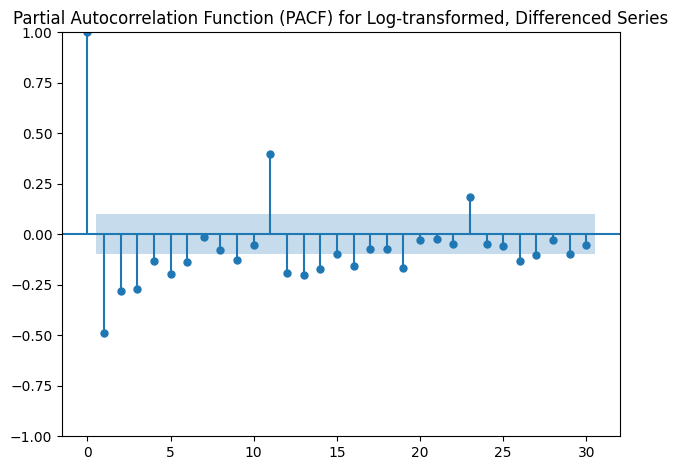

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(both_diff.iloc[:, 0], lags=30, alpha=0.05, title='Autocorrelation Function (ACF) for Log-transformed Differenced Series')
plt.tight_layout()

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(both_diff.iloc[: , 0], lags=30, alpha=0.05, title='Partial Autocorrelation Function (PACF) for Log-transformed, Differenced Series')
plt.tight_layout()

plt.show()

In [23]:
# Note: We drop the first NaN value that results from differencing
series = df['Recoveries']

# Use auto_arima to find the optimal SARIMA model
auto_model = auto_arima(series,
                        start_p=0, start_q=0,
                        max_p=20, max_q=20,  # Maximum p and q
                        m=12,  # Adjust this based on your seasonality (e.g., 12 for monthly data with annual seasonality)
                        start_P=0, start_Q=0, 
                        max_P=20, max_Q=20,
                        seasonal=True,  # Enable search for seasonal parameters
                        D=1,  # Assuming one seasonal differencing. Adjust as needed.
                        test='adf',  # Use ADF test to find optimal 'd'
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2620.964, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2498.035, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2618.996, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2617.839, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2471.575, Time=1.16 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=2443.431, Time=1.89 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=2402.713, Time=3.36 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=2401.225, Time=13.33 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=2390.466, Time=15.61 sec
 ARIMA(1,0,0)(7,1,0)[12] intercept   : AIC=2392.454, Time=23.51 sec
 ARIMA(1,0,0)(6,1,1)[12] intercept   : AIC=2389.753, Time=26.42 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=40.39 sec
 ARIMA(1,0,0)(7,1,1)[12] intercept   : AIC=2390.003, Time=50.49 sec
 ARIMA(1,0,0)(6,1,2)[12

In [ ]:
# Extract the order (p, d, q)
order = auto_model.order

# Extract the seasonal order (P, D, Q, m)
seasonal_order = auto_model.seasonal_order

print(f"Non-seasonal order: {order}")
print(f"Seasonal order: {seasonal_order}")

Non-seasonal order: (1, 0, 1)
Seasonal order: (6, 1, 0, 12)


Test RMSE: 2.684540405402945


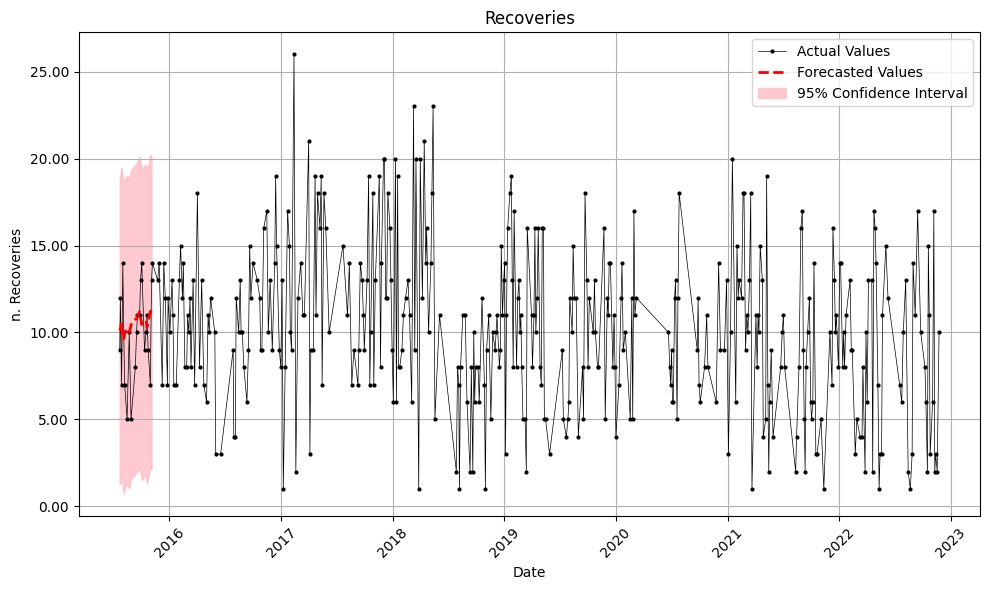

In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - series_test)**2))
print(f'Test RMSE: {rmse}')


# Plotting the forecast along with the actual series and confidence intervals
plt.figure(figsize=(10, 6))
# Plotting the entire original series
plt.plot(series.index, series, marker='o', linestyle='-', color='black', markersize=2, linewidth=0.5, label='Actual Values')

# Plotting the forecasted values on the test set
plt.plot(series_test.index, predictions, label='Forecasted Values', color='red', linestyle='--', linewidth=2)

# Extracting lower and upper confidence bounds
lower_bounds = [ci[0] for ci in confidence_intervals]
upper_bounds = [ci[1] for ci in confidence_intervals]

# Plotting the confidence interval
plt.fill_between(series_test.index, lower_bounds, upper_bounds, color='pink', alpha=0.85, label='95% Confidence Interval')

plt.title('Recoveries')
plt.xlabel('Date')
plt.ylabel('n. Recoveries')
plt.grid(True)

# Formatting y-axis labels to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2f}'.format(x)))

# Ensuring dates are nicely formatted and readable
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()
